# English to French using Neural Machine Translation

This example was taken from the wonderful Cutting Edge Deep Learning for Coders course as taught by Jeremy Howard http://course.fast.ai/part2.html The course is now live and I encourage you to check it out.

In [1]:
%matplotlib inline
import importlib
#import sutils; importlib.reload(sutils)
from sutils import *

import keras
import gensim
import re
import pickle
import keras.backend as K

from keras import initializers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TensorBoard
from keras.callbacks import LambdaCallback


from recurrentshop import *
import seq2seq
from seq2seq.models import AttentionSeq2Seq,SimpleSeq2Seq, Seq2Seq

import tensorflow as tf
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [2]:
print(keras.__version__)
print(tf.__version__)

2.0.8
1.3.0


In [3]:
from gensim.models import word2vec

In [4]:
#limit_gpu_mem()

In [5]:
path = '/data/TensorFlowTalks/neural_translation/'
dpath = '/data/TensorFlowTalks/neural_translation/translate/'

### Set up Regex and tokenize for use later

In [6]:
re_mult_space = re.compile(r"  *")
re_mw_punc = re.compile(r"(\w[’'])(\w)")
re_punc = re.compile("([\"().,;:/_?!—])")
re_apos = re.compile(r"(\w)'s\b")


def simple_toks(sent):
    sent = re_apos.sub(r"\1 's", sent)
    sent = re_mw_punc.sub(r"\1 \2", sent)
    sent = re_punc.sub(r" \1 ", sent).replace('-', ' ')
    sent = re_mult_space.sub(' ', sent)
    return sent.lower().split()

## Load the PreProcessed data

Here we load all the data 

In [7]:
data = load(dpath+'nmt_data.pkl')
look_ups = load(dpath+'look_ups.pkl')
fr_train = data['fr_train']
fr_test = data['fr_test']
en_train = data['en_train']
en_test = data['en_test']
en_w2id = look_ups['en_w2id']
fr_vocab = look_ups['fr_vocab']
en_vocab = look_ups['en_vocab']
en_embs = look_ups['en_embs']
fr_embs = look_ups['fr_embs']

questions = load(dpath+'questions.pkl')
print(questions[10])
en_qs, fr_qs = zip(*questions)

('Which province has the highest population density?', 'Quelle est la province ayant la plus forte densité de population ?')


In [8]:
validation_set = load(dpath+'validation_set.pkl')

In [11]:
print(validation_set[0][0])
print(validation_set[0][1])

When will the ozone layer finally recover?
Quand la couche dâ€™ozone sera-t-elle finalement remplacÃ©e?


In [12]:
# for running model test on small set of data
#fr_train = fr_train[:5000]
#en_train = fr_train[:5000]

fr_train.shape

(47097, 30)

In [13]:
en_train.shape

(47097, 30)

## Model

#### Create some Keras Callbacks to handle early stopping and Learning Rate changes

In [14]:
reduce_LR = ReduceLROnPlateau(monitor='val_loss',factor = 0.5, patience=0,cooldown=1, min_lr = 0.00001)
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=4,verbose=0,mode='auto')

import math

# learning rate schedule for dropping every 10 epochs
def LRDropping(epoch):
    initial_lrate = 0.001
    drop = 0.9
    epochs_drop = 3.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# try at manual setting of LR for Epochs
def fixed_dropping(epoch):
    if epoch < 2: 
        lrate = 0.01
    elif epoch < 4: 
        lrate = 0.001
    elif epoch < 7: 
        lrate = 0.0005
    else:
        lrate = 0.0001
    print(lrate)
    return lrate

LRDrop = LearningRateScheduler(fixed_dropping)

In [15]:
# creating different sets of Params to easily import into the model at train time
params = {'verbose': 1, 'callbacks': [TQDMNotebookCallback(),reduce_LR,early_stopping]}
params2 = {'verbose': 1, 'callbacks': [LRDrop,TQDMNotebookCallback(),reduce_LR,early_stopping]}
params3 = {'verbose': 1, 'callbacks': [LRDrop,TQDMNotebookCallback(),reduce_LR,early_stopping]}

#### Set some parameters for the model

In [16]:
lr = 1e-3
maxlen = 30
dim_en_vec = 100
n_en_vec = 400000
dim_fr_vec = 200

vocab_size = len(fr_vocab) #the output vocab # embeddings.shape[0]
embedding_size = 100 #The english inputs embeddings embeddings.shape[1]

In [17]:
fr_wgts = [fr_embs.T, np.zeros((len(fr_vocab,)))]

### The model itself

In [18]:
inp = Input((maxlen,))
x = Embedding(len(en_vocab), dim_en_vec, input_length=maxlen,
              weights=[en_embs], trainable=False)(inp)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = LSTM(128, return_sequences=True)(x)
x = TimeDistributed(Dense(dim_fr_vec))(x)
x = TimeDistributed(Dense(len(fr_vocab), weights=fr_wgts))(x)
x = Activation('softmax')(x)

In [19]:
model = Model(inp, x)
model.compile('adam', 'sparse_categorical_crossentropy')

In [20]:
K.set_value(model.optimizer.lr, lr)

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 100)           1954800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 256)           234496    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 256)           394240    
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           197120    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 200)           25800     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 26708)         5368308   
__________

In [18]:
hist=model.fit(en_train, np.expand_dims(fr_train,axis=-1), batch_size=64, epochs=20, **params, 
               validation_data=[en_test, np.expand_dims(fr_test,axis=-1)])

Train on 47097 samples, validate on 5234 samples


HBox(children=(IntProgress(value=0, description='Training', max=20), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=47097), HTML(value='')))

Epoch 1/20
47097/47097 [==============================] - 193s - loss: 3.5289 - val_loss: 3.2824


HBox(children=(IntProgress(value=0, description='Epoch 1', max=47097), HTML(value='')))

Epoch 2/20
47097/47097 [==============================] - 192s - loss: 3.2291 - val_loss: 3.1779


HBox(children=(IntProgress(value=0, description='Epoch 2', max=47097), HTML(value='')))

Epoch 3/20
47097/47097 [==============================] - 192s - loss: 3.1097 - val_loss: 3.0861


HBox(children=(IntProgress(value=0, description='Epoch 3', max=47097), HTML(value='')))

Epoch 4/20
47097/47097 [==============================] - 192s - loss: 3.0136 - val_loss: 3.0205


HBox(children=(IntProgress(value=0, description='Epoch 4', max=47097), HTML(value='')))

Epoch 5/20
47097/47097 [==============================] - 192s - loss: 2.9271 - val_loss: 2.9618


HBox(children=(IntProgress(value=0, description='Epoch 5', max=47097), HTML(value='')))

Epoch 6/20
47097/47097 [==============================] - 192s - loss: 2.8359 - val_loss: 2.8957


HBox(children=(IntProgress(value=0, description='Epoch 6', max=47097), HTML(value='')))

Epoch 7/20
47097/47097 [==============================] - 191s - loss: 2.7489 - val_loss: 2.8362


HBox(children=(IntProgress(value=0, description='Epoch 7', max=47097), HTML(value='')))

Epoch 8/20
47097/47097 [==============================] - 192s - loss: 2.6737 - val_loss: 2.8024


HBox(children=(IntProgress(value=0, description='Epoch 8', max=47097), HTML(value='')))

Epoch 9/20
47097/47097 [==============================] - 191s - loss: 2.6070 - val_loss: 2.7727


HBox(children=(IntProgress(value=0, description='Epoch 9', max=47097), HTML(value='')))

Epoch 10/20
47097/47097 [==============================] - 192s - loss: 2.5483 - val_loss: 2.7495


HBox(children=(IntProgress(value=0, description='Epoch 10', max=47097), HTML(value='')))

Epoch 11/20
47097/47097 [==============================] - 190s - loss: 2.4952 - val_loss: 2.7286


HBox(children=(IntProgress(value=0, description='Epoch 11', max=47097), HTML(value='')))

Epoch 12/20
47097/47097 [==============================] - 191s - loss: 2.4481 - val_loss: 2.7241


HBox(children=(IntProgress(value=0, description='Epoch 12', max=47097), HTML(value='')))

Epoch 13/20
47097/47097 [==============================] - 191s - loss: 2.4017 - val_loss: 2.6986


HBox(children=(IntProgress(value=0, description='Epoch 13', max=47097), HTML(value='')))

Epoch 14/20
47097/47097 [==============================] - 191s - loss: 2.3580 - val_loss: 2.6989


HBox(children=(IntProgress(value=0, description='Epoch 14', max=47097), HTML(value='')))

Epoch 15/20
47097/47097 [==============================] - 191s - loss: 2.2724 - val_loss: 2.6854


HBox(children=(IntProgress(value=0, description='Epoch 15', max=47097), HTML(value='')))

Epoch 16/20
47097/47097 [==============================] - 191s - loss: 2.2444 - val_loss: 2.6884


HBox(children=(IntProgress(value=0, description='Epoch 16', max=47097), HTML(value='')))

Epoch 17/20
47097/47097 [==============================] - 191s - loss: 2.1942 - val_loss: 2.6898


HBox(children=(IntProgress(value=0, description='Epoch 17', max=47097), HTML(value='')))

Epoch 18/20
47097/47097 [==============================] - 191s - loss: 2.1654 - val_loss: 2.6894


HBox(children=(IntProgress(value=0, description='Epoch 18', max=47097), HTML(value='')))

Epoch 19/20
47097/47097 [==============================] - 190s - loss: 2.1499 - val_loss: 2.6892


HBox(children=(IntProgress(value=0, description='Epoch 19', max=47097), HTML(value='')))

Epoch 20/20
47097/47097 [==============================] - 191s - loss: 2.1417 - val_loss: 2.6916



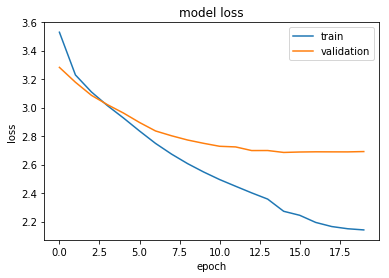

In [24]:
plot_train(hist)

In [25]:
model.save_weights(dpath+'trans_testing_basic2.h5')

In [22]:
model.load_weights(dpath+'trans_testing_basic2.h5')

## Testing

In [23]:
def sent2ids(sent):
    sent = simple_toks(sent)
    ids = [en_w2id[t] for t in sent]
    return pad_sequences([ids], maxlen, padding="post", truncating="post")

In [24]:
def en2fr(sent): 
    ids = sent2ids(sent)
    tr_ids = np.argmax(model.predict(ids), axis=-1)
    return ' '.join(fr_vocab[i] for i in tr_ids[0] if i>0)

In [25]:
en2fr("what is the size of canada?")


'quel est le il de canada ?'

In [26]:
en2fr("what is the size of australia?")


'quel est le t de ? ?'

In [27]:

print(fr_qs[0])
en2fr("What is light?")

Qu’est-ce que la lumière?


"qu' est ce que le ? ?"

In [28]:
print(fr_qs[50000])
en2fr("Why is the Arctic ozone layer thicker than the Antarctic ozone layer?")


Pourquoi la couche d'ozone arctique est-elle plus épaisse que celle située au-dessus de l'Antarctique?


'pourquoi le mois des est t de de de de de de de de de de de de ? ?'

In [30]:
en2fr("Which province is the most populated?")

'quelle quelle est le le le ?'

In [31]:
en2fr("Who are we?")

'qui sont nous ?'

In [32]:
print(fr_qs[3])
en2fr("What would we do without it?")

Que ferions-nous sans elle ?


'que contractante nous faire ? ?'

In [38]:
en_val = []
for val_tuple in validation_set:
    en_val.append(val_tuple[0])
print(len(en_val))
print(en_val[2000])

5234
Which priority would it give to youth policy?


In [39]:
import os

source_file = "/data/wrapper/PA_BA/DataSets/Validation/DE_EN_(tatoeba)_validation_english_only.txt"
print(len(en_test), len(fr_test))

translated_sentences = []
i = 0
for sent in en_val:
    if i % int((len(en_test) / 100)) == 0:
        print(i)
    translated_sentences.append(en2fr(sent))
    i += 1
print(len(translated_sentences))

5234 5234
0
52
104
156
208
260
312
364
416
468
520
572
624
676
728
780
832
884
936
988
1040
1092
1144
1196
1248
1300
1352
1404
1456
1508
1560
1612
1664
1716
1768
1820
1872
1924
1976
2028
2080
2132
2184
2236
2288
2340
2392
2444
2496
2548
2600
2652
2704
2756
2808
2860
2912
2964
3016
3068
3120
3172
3224
3276
3328
3380
3432
3484
3536
3588
3640
3692
3744
3796
3848
3900
3952
4004
4056
4108
4160
4212
4264
4316
4368
4420
4472
4524
4576
4628
4680
4732
4784
4836
4888
4940
4992
5044
5096
5148
5200
5234


In [41]:
out_file = os.path.join(os.path.abspath(os.path.join(source_file, os.pardir)), "trans_testing_basic2_fr_en" + ".pred")
with(open(out_file, 'w', encoding='utf8')) as file:
    for sent in translated_sentences:
        file.write(sent + '\n')

In [42]:
out_file = os.path.join(os.path.abspath(os.path.join(source_file, os.pardir)), "EN_FR_NMT_Keras_validation_france_only.txt")
with(open(out_file, 'w', encoding='utf8')) as file:
    for val_tuple in validation_set:
        file.write(val_tuple[1] + '\n')

In [43]:
for val_tuple in validation_set:
    print(val_tuple[1])
    break

Quand la couche dâ€™ozone sera-t-elle finalement remplacÃ©e?
